# **Trabajo práctico 1: Clasificiones con Decision Trees y Naive Bayes** 
**Integrantes:** Rodrigo Mauriño, Martín Llada, Juan Jose Iguaran

El objetivo de este trabajo es lograr entrenar modelos clasificatorios que permitan predecir y analizar el otorgamiento de préstamos hipotecarios. En este sentido, se evalúa si el aplicante n, dadas sus caracetristicas -los valores de los atributos X- es elegible para el crédito. La base de datos consiste en informacion sobre créditos para vivivienda en el estado de Nueva York, EE.UU. 
En primer lugar, y en pos de entrenar los modelos clasificatorios, es necesario alistar el framework mediante la importacion de las librerías necesarias:

# Importación de librerías y base de datos

In [1]:
import os
import pandas as pd 
import numpy as np
import sklearn as sk
import random
from sklearn import model_selection
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB

Una vez importadas las librerías, es necesario importar el dataset a ser utlizado, asi como una pequeña visualización del mismo:

In [2]:
data = pd.read_csv("baseclean.csv")
dataf=data.copy()
dataf=dataf.dropna()
dataf.head()

,action_taken,agency_code,applicant_ethnicity,applicant_income_000s,applicant_race_1,applicant_sex,application_date_indicator,census_tract_number,co_applicant_ethnicity,co_applicant_race_1,...,property_type,purchaser_type,sequence_number,hud_median_family_income,loan_amount_000s,number_of_1_to_4_family_units,number_of_owner_occupied_units,minority_population,population,tract_to_msamd_income
0,1,9,3,230.0,6,3,0,319.00,5,8,...,1,0,155085,82700.0,159,2414.0,2077.0,14.770000,7442.0,138.440002
1,1,7,1,66.0,6,1,0,602.02,3,5,...,2,0,37462,95200.0,47,1422.0,1298.0,19.690001,3997.0,85.000000
3,1,5,2,174.0,5,1,0,502.03,2,5,...,1,0,20,95200.0,40,1723.0,1578.0,17.639999,4971.0,119.169998
4,1,9,2,100.0,5,2,0,195.00,5,8,...,1,0,12370,71300.0,378,615.0,738.0,60.779999,3366.0,78.169998
5,1,7,2,155.0,5,1,0,3037.00,2,5,...,1,1,143,109000.0,352,2008.0,2041.0,22.570000,6718.0,87.589996


Dado que una de las variables es un string (*nombre del condado*), se procede a realizar una transformación de ésta con el objeto de obtener una variable en numérica, mediante la función label_encoder. Luego se reemplaza los valores originales por los obtenidos a partir de dicha transformación para poder ejecutar el algorítmo. Asi mismo, es necesario transformar la variable objetivo, *action_taken*, en una variable binaria en pos de calcular las medidas de desempeño. En este sentido, que se procede a crear una lista que contiene los índices que resultaron en un crédito aprobado. Luego se asigna el valor 1 si la observación se ecuentra dentro de los valores de la lista y 0 en caso contrario:

In [3]:
values = np.array(dataf["county_name"])
integer_encoded = sk.preprocessing.LabelEncoder().fit_transform(values)
dataf.loc[:,"county_name"]=integer_encoded
lista = [1,5,6]
target_encoded =dataf['action_taken'].isin(lista).astype(int)

# Partición de datos
Una vez que los datos se encuentran en un formato apto para su procesamineto, se procede a ejecutar la partición de los mismos. La separación del conjunto de datos en uno de desarrollo y otro de testeo, como sugiere la teoría, se realizará tanto para la varible objetivo a predecir (target_encoded - *Y*), como par los parámetros (atributos - *X*). Tal separación se realizará de la siguiente manera: un 80% de los datos se destinan para el desarrollo y el 20% remanente se destina para testeo:

In [4]:
X=dataf.iloc[:,1:]
Y=target_encoded
dev_x, test_x, dev_y, test_y = model_selection.train_test_split(X,Y,train_size=0.8, test_size=0.2,random_state=123)

# Árboles de decisión

## Árbol de altura 3

Con el objetivo de realizar una validación cruzada que permita calcular las medidas de desempeño tanto para los datos de entrenamiento como para los de validación, se procede a implementar la función *cross_val_nuevo(x_set, y_set, n_folds, tree, perf)*, la cual tomará como valores de entrada (*inputs*) el set de datos, el set de datos a predecir, el número de particiones, un modelo predictivo y el tipo de medida de desempeño. Está función tendrá como salida (*output*) dos listas, ambas con una longitud igual al número de particiones, el cual vendrá determinado por *n-folds*. Los elemento correspondiente sa la pirmera lista corresponden a los puntajes para los datos de entrenamiento, mientras que los elemntos de la segunda lista correspondena los puntajes para los datos de validación:

In [5]:
def cross_val_nuevo(x_set, y_set, n_folds, model, perf):
    tree = sk.base.clone(model)
    index = random.sample(range(x_set.shape[0]), x_set.shape[0])
    n = int(x_set.shape[0]/n_folds)
    list_x = []
    list_y = []
    train_score = []
    val_score = []
    for i in range(n_folds):
        fold_x = x_set.iloc[index[n*i:n*(i+1)],].copy()
        list_x.append(fold_x)
        fold_y = y_set.iloc[index[n*i:n*(i+1)],].copy()
        list_y.append(fold_y)
    for i in range(n_folds):
        val_x = list_x[i].copy()
        val_y = list_y[i].copy()
        train_x = list_x.copy()
        train_y = list_y.copy()
        del train_x[i]
        del train_y[i]
        x = pd.concat(train_x)
        y = pd.concat(train_y)
        tree.fit(x,y)
        pred_train = tree.predict(x)
        pred_val = tree.predict(val_x)
        if perf == 'acc':
            train_score.append(round(sk.metrics.accuracy_score(y,pred_train), 3))
            val_score.append(round(sk.metrics.accuracy_score(val_y,pred_val), 3))
        elif perf == 'roc':
            train_score.append(round(sk.metrics.roc_auc_score(y,pred_train), 3))
            val_score.append(round(sk.metrics.roc_auc_score(val_y,pred_val), 3))
    return train_score,val_score        

Se procede a crear un objeto tipo *DecisionTreeClassifier* con altura máxima altura 3 manteniendo el resto de los hiperparámetros en su valor preestablecido:

In [11]:
dtree =sk.tree.DecisionTreeClassifier(max_depth = 3)

Una vez creado el objeto, se procede a estimar el desempeño del modelo utilizando *5-fold cross validation* a través de la función previamente mencionada *cross_val_nuevo*, utilizando la medida de accuracy:

In [12]:
perf_3tree = cross_val_nuevo(dev_x, dev_y, 5, dtree, 'acc')
perf_3tree

([0.787, 0.803, 0.787, 0.799, 0.792], [0.786, 0.784, 0.79, 0.788, 0.739])

Se puede apreciar que para el árbol entrenado, la precisión se encuentra alrededor del 80% aproximadamente para los datos de entrenamiento. Asi mismo, se evidencia que para los datos de validación se tiene una medida parecida de performance. 
A su vez, interesa conocer otra medida de perfomance del modelo. En este sentido, se procede a estimar el desempño de éste mismo arbol, pero utilizando la medida roc_auc:

In [13]:
perf_3tree_roc = cross_val_nuevo(dev_x, dev_y, 5, dtree, 'roc')
perf_3tree_roc

([0.742, 0.782, 0.743, 0.797, 0.787], [0.721, 0.771, 0.71, 0.754, 0.798])

Como puede apreciarse, si bien los resultados obtenidos utilizando esta medida son similares a los obtenidos utilizando la medida accuracy, éstos son levemente inferiores respecto a ésta última métrica. A continuación se calcularán las medias y los desvíos estándar para todos las medidas de performance previamente calculadas.En primer lugar, se transformarán las listas en un arreglo de numpy:

In [15]:
train_acc = np.array(perf_3tree[0])
val_acc = np.array(perf_3tree[1])
train_roc = np.array(perf_3tree_roc[0])
val_roc = np.array(perf_3tree_roc[1])
print("Media accuracy - Train= ",round(train_acc.mean(),3))
print("Desvío estándar accuracy - Train= ",round(train_acc.std(),3))
print("Media accuracy - Validation= ",round(val_acc.mean(),3))
print("Desvío estándar accuracy - Validation= ",round(val_acc.std(),3))
print("Media roc - Train= ",round(train_roc.mean(),3))
print("Desvío estándar roc - Train= ",round(train_roc.std(),3))
print("Media roc - Validation= ",round(val_roc.mean(),3))
print("Desvío estándar accuracy - Validation= ",round(val_roc.std(),3))

Media accuracy - Train=  0.794
Desvío estándar accuracy - Train=  0.006
Media accuracy - Validation=  0.777
Desvío estándar accuracy - Validation=  0.019
Media roc - Train=  0.77
Desvío estándar roc - Train=  0.023
Media roc - Validation=  0.751
Desvío estándar accuracy - Validation=  0.032


Se puede apreciar que para ambas medidas, la media es más alta y la desviación estándar es más baja para los datos de entrenamiento, lo cual parece indicar -y de manera consistente con lo espeado- que el modelo se comporta mejor para el conjunto de datos con los cuales fue entrenado. Por otro lado, tambien se evidencia que la medida de acucracy es significativamente mejor en todos los casos que el roc_auc.

## Árboles de diferentes combinaciones


En este apartado, se entrenan diferentes combinaciones de modelos variando los hiperparámetros. En primer lugar, con el objeto de entrenar un arbol que sea comparable con el previamente entrenado, sólo se procede a crear un nuevo árbol de la misma profundidad, pero esta vez utilizando como criterio el *information gain* en lugar de Gini:

In [10]:
dtree_ig= sk.tree.DecisionTreeClassifier(criterion = 'entropy',max_depth = 3)

Con el nuevo árbol, se calcularán las mismas métricas obtenidas anteriormente:

In [11]:
acc_results_ig = cross_val_nuevo(dev_x, dev_y, 5, dtree_ig, 'acc')
roc_results_ig = cross_val_nuevo(dev_x, dev_y, 5, dtree_ig, 'roc')
print(acc_results_ig)
print(roc_results_ig)

([0.787, 0.783, 0.79, 0.802, 0.789], [0.761, 0.808, 0.781, 0.777, 0.786])
([0.784, 0.795, 0.733, 0.791, 0.796], [0.762, 0.777, 0.732, 0.775, 0.785])


Como se puede apreciar, no se evidencia una diferencia significativa entre las medidas obtenidas a partir de la utiliación de infromation gane. A continuación se crearan dos árboles utilizando ambos criterios pero esta vez, con una altura de 6 (donde gn: corresponde a GINI e ig: corresponde a *information gain*):

In [12]:
dtree_6_gn= sk.tree.DecisionTreeClassifier(max_depth = 6)
dtree_6_ig= sk.tree.DecisionTreeClassifier(criterion = 'entropy',max_depth = 6)

Se calcularán ahora las metricas de costumbre, iniciando con el árbol creado utilizando GINI:

In [13]:
acc_results_6 = cross_val_nuevo(dev_x, dev_y, 5, dtree_6_gn, 'acc')
roc_results_6 = cross_val_nuevo(dev_x, dev_y, 5, dtree_6_gn, 'roc')
print(acc_results_6)
print(roc_results_6)

([0.851, 0.848, 0.849, 0.866, 0.853], [0.815, 0.835, 0.818, 0.799, 0.815])
([0.837, 0.843, 0.831, 0.828, 0.831], [0.777, 0.793, 0.746, 0.81, 0.777])


A partir de este ejercicio, se puede observar la mejora en el desempeño del modelo derivada, lo cual se aprecia en todas las metricas estudiadas. Por tanto, se puede concluir que un árbol de profundidad 6 ajusta mejor al dataset en cuestión. Ahora se calcularán las mismas métricas para el árbol entrenado a partir de information gane:

In [14]:
acc_results_6_ig = cross_val_nuevo(dev_x, dev_y, 5, dtree_6_ig, 'acc')
roc_results_6_ig = cross_val_nuevo(dev_x, dev_y, 5, dtree_6_ig, 'roc')
print(acc_results_6_ig)
print(roc_results_6_ig)

([0.846, 0.857, 0.844, 0.856, 0.846], [0.811, 0.82, 0.845, 0.806, 0.795])
([0.811, 0.83, 0.826, 0.817, 0.808], [0.761, 0.799, 0.771, 0.767, 0.791])


Se evidencia que las metricas obtenidas a partir de un modelo entrenado utlizando el criterio *information gane*, son bastante similares a las observadas aquellas obtenidas de un modelo que utiliza el GINI gain. Sin embargo, aunque algunas tuvieron mejor desempeño, puede decirse que hay una leve mejoria con GINI. Ahora se creará un árbol utilizando ambos criterios pero sin especificar la altura máxima :

In [7]:
dtree_max_gn= sk.tree.DecisionTreeClassifier()
dtree_max_ig= sk.tree.DecisionTreeClassifier(criterion = 'entropy')

De la misma forma en que se opero durante el ejercicio previamente realizado, se calcularán las métricas de costumbre utilizando el criterio GINI, teniendo en cuenta que a partir de este criterio se obtuvieron los mejores resultados en términos de performance:

In [26]:
acc_results_max = cross_val_nuevo(dev_x, dev_y, 5, dtree_max_gn, 'acc')
roc_results_max = cross_val_nuevo(dev_x, dev_y, 5, dtree_max_gn, 'roc')
print(acc_results_max)
print(roc_results_max)

([1.0, 1.0, 1.0, 1.0, 1.0], [0.784, 0.761, 0.788, 0.779, 0.768])
([1.0, 1.0, 1.0, 1.0, 1.0], [0.74, 0.734, 0.735, 0.71, 0.742])


Como puede apreciarse, al no especificar la profundida del árbol, el modelo incurre en overfitting o sobre-ajuste: predice de manera exacta para los datos de entrenamiento en ambas medidas de performance, mientras que los puntajes para los datos de validación son menores que aquellos obtenidos para los árboles anteriores, por lo que pierde capacidad de predicción. A continuacion se procede a calcular las mismas metricas para el arbol entrenado a partir de information gane.

In [27]:
acc_results_max_ig = cross_val_nuevo(dev_x, dev_y, 5, dtree_max_ig, 'acc')
roc_results_max_ig = cross_val_nuevo(dev_x, dev_y, 5, dtree_max_ig, 'roc')
print(acc_results_max_ig)
print(roc_results_max_ig)

([1.0, 1.0, 1.0, 1.0, 1.0], [0.77, 0.79, 0.772, 0.793, 0.752])
([1.0, 1.0, 1.0, 1.0, 1.0], [0.755, 0.694, 0.755, 0.767, 0.765])


Se observa un comportamiento muy semejante al obtenido con GINI, por lo que se concluye no existe gran diferencia en cuanto a metodo de seleccion.

# Tratamiento de datos faltantes

En este apartado se evalúa la influencia de datos faltantes sobre la perofmance del modelo utilizando diferentes estrategías de relleno. A continuación se implementa la funcion *outliers(data,clase, index, por, rell)*, la cual recibirá el set de datos asi como la variable a predecir, el índice del atributo a modificar, un porcentaje de datos faltantes y una estrategía de de relleno que podrá ser moda o clase modal. A su vez, esta función devolverá como salida un nuevo data frame que tendrá el porcentaje de datos faltantes rellenados con la estrategía de relleno correspondiente:

In [17]:
def outliers(data,clase,index, por, rell):
    new = data.copy()
    n = int(new.shape[0]*(por/100))
    rand = random.sample(range(new.shape[0]), n) 
    for i in rand:
        new.iloc[i,index] = np.nan
    if rell == 'mode':
        mode = int(new.iloc[:,index].mode())
        for i in rand:
            new.iloc[i,index] = mode
    elif rell == 'class_mode':
        feat = new.iloc[:,index]
        for i in rand:
            mode = int(feat[clase == clase.iloc[i]].mode())
            new.iloc[i,index] = mode
    return new

Para las siguientes evaluaciones se utilizará el 80% de los datos de desarrollo, pues el otro 20% será empleado en la tarea de validación:

In [18]:
des_x, val_x, des_y, val_y = model_selection.train_test_split(dev_x,dev_y,train_size=0.8, test_size=0.2,random_state=123)

A partir de los resultados hallados en el apartado número 4, se puede concluir que el árbol con mejor desempeño fue aquel construído utilizando el *GINI gain* con una profundidad máxima de 6. Teniendo en cuenta ésto ultimo, se utilizará esta configuración en el siguiente análisis. A su vez, en pos de evaluar la influencia de los datos faltantes, el proceso será más notorio si dichos datos faltantes se encuentran en el atrbuto mas relevante. En este sentido, a continuación se creará y entrenará un arbol con las características previamente mencionadas, en pos de obtener el índice de dicho atributo:

In [19]:
opt_tree= sk.tree.DecisionTreeClassifier(max_depth = 6)
opt_tree.fit(des_x,des_y)
importance = opt_tree.feature_importances_
index = np.argmax(importance)
print(index)

20


## Ejecución en distintos datasets

Una vez que ya conocemos el atributo más relevante y su índice, se procede a generar dos lista de datasets con diferentes cantidades de datos faltantes, desde 0 a 80% variando en intervalos de 5%. A la primera lista se le aplicará la estrategia de relleno siguiendo el método de modas, mientras que a la segunda lista se le aplicará el método de modas de clase. Esta distinción se realiza con el objetivo de evaluar posteriormente el desempeño de árboles entrenados con cada uno de estos datasets:

In [20]:
list_mode = []
list_class_mode = []
list_mode.append(des_x.copy())
list_class_mode.append(des_x.copy())
for i in range(5,85,5):
    list_mode.append(outliers(des_x,des_y,index, i, 'mode'))    
    list_class_mode.append(outliers(des_x,des_y,index, i, 'class_mode'))

Una vez creados los datasets, se procede a entrenar modelos con ellos para calcular el tamaño y el performance de cada uno para poder compararlos según estas medidas:

In [21]:
tree_size_mode = []
acc_mode = []
tree_size_class_mode = []
acc_class_mode =[]
for i in range(len(list_mode)):
    tree_mode = sk.tree.DecisionTreeClassifier(max_depth = 6)
    tree_mode.fit(list_mode[i],des_y)
    tree_size_mode.append(tree_mode.tree_.node_count)
    pred_mode = tree_mode.predict(val_x)
    acc_mode.append(sk.metrics.accuracy_score(val_y,pred_mode))
    tree_class_mode = sk.tree.DecisionTreeClassifier(max_depth = 6)
    tree_class_mode.fit(list_class_mode[i],des_y)
    tree_size_class_mode.append(tree_class_mode.tree_.node_count)
    pred_class_mode = tree_class_mode.predict(val_x)
    acc_class_mode.append(sk.metrics.accuracy_score(val_y,pred_class_mode)) 

## Tamaño del árbol vs porcentaje de faltantes

En pos de poder apreciar el comportamiento del tamaño del árbol ante datos faltante, a continuacion se realizan las gráficas del tamaño del árbol en función del porcentaje de faltantes, tanto para los reemplazados por moda como para aquellos en los cuales el relleno se ha realizado según la clase modal:

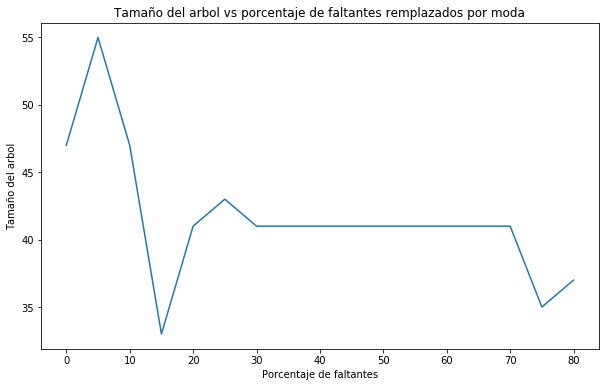

In [22]:
plt.figure(figsize=(10,6))
plt.plot(list(range(0,85,5)), tree_size_mode)
plt.title('Tamaño del arbol vs porcentaje de faltantes remplazados por moda')
plt.ylabel('Tamaño del arbol')
plt.xlabel('Porcentaje de faltantes')
plt.show()

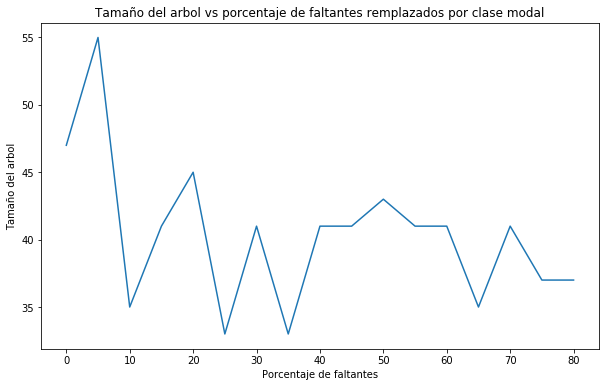

In [23]:
plt.figure(figsize=(10,6))
plt.plot(list(range(0,85,5)), tree_size_class_mode)
plt.title('Tamaño del arbol vs porcentaje de faltantes remplazados por clase modal')
plt.ylabel('Tamaño del arbol')
plt.xlabel('Porcentaje de faltantes')
plt.show()

Aún cuando se pueden apreciar leves diferencias entre las gráficas, de ambos se reriva una clara relación entre ambas variables: a mayor porcentaje de faltantes, disminuye el tamaño del árbol. 

## Performance vs porcentaje de faltantes

De igual manera, se realizan los gráficos de la performance en función del porcentaje de faltantes, tanto para los reemplazados por moda, como para aquellos rellenos mediante la clase modal:

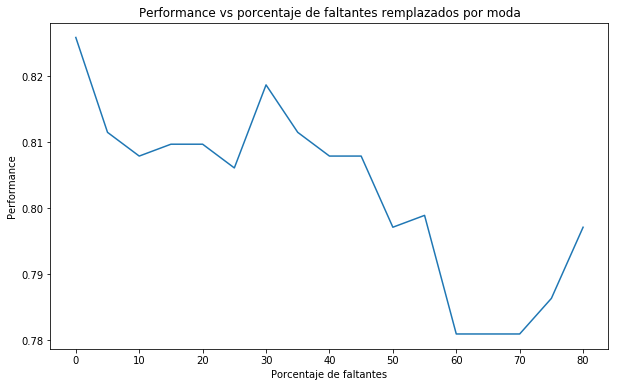

In [24]:
plt.figure(figsize=(10,6))
plt.plot(list(range(0,85,5)), acc_mode)
plt.title('Performance vs porcentaje de faltantes remplazados por moda')
plt.ylabel('Performance')
plt.xlabel('Porcentaje de faltantes')
plt.show()

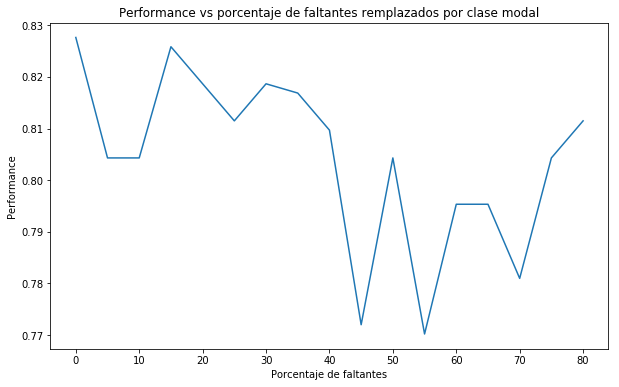

In [25]:
plt.figure(figsize=(10,6))
plt.plot(list(range(0,85,5)), acc_class_mode)
plt.title('Performance vs porcentaje de faltantes remplazados por clase modal')
plt.ylabel('Performance')
plt.xlabel('Porcentaje de faltantes')
plt.show()

Al igual que con el tamaño del árbol, aún cuando existen leves diferencias entre las gráficas, se puede concluir que existe una relacion entre la perfomance y el porcentaje de faltantes, a saber: a mayor porcentaje de faltantes, disminuye la performance independiente de la estrategía de relleno.

## Análisis

A partir de los diferentes gráficos expuestos en las secciones 5.2 y 5.3, se puede concluir que: conforme se incrementa el porcentaje de datos faltantes, él arbol disminuye no sólo su capacidad para generar caminos exitosos y, por consiguiente, su capacidad de predecir, sino que también su tamaño. Además, el comportamiento de ambas estrategías de relleno es bastante similar, por lo tanto es los resultados parence indicar cierta indiferencia sobre la estrategia a utlizar en pos de realizar un tratamiento de outliers.

# Tolerancia al ruido.
Para evaluar la influencia del ruido -cambios en los datos- sobre un atributo de un data set, a continuación se implementa la función *ind_ruido(data, index, porcentaje)*, la cual recibirá el set de datos, el índice del atributo a modificar y un porcentaje de datos con ruído. A su vez, dicha función devolverá como salida un nuevo data frame que tendrá el porcentaje de datos con ruido:    

In [17]:
def ind_ruido(data,index,porcentaje):
    new=data.copy()
    n=int(new.shape[0]*(porcentaje/100))
    rand=random.sample(range(new.shape[0]),n)
    for i in rand:
        noise = np.random.normal(new.iloc[:,index].mean(),new.iloc[:,index].mean()+1000000,1)
        valor=(new.iloc[i,index])+noise
        new.iloc[i,index]=valor
    return new

Para las siguientes evaluaciones se utilizará el 80% de los datos de desarrollo, ya que el otro 20% sera empleado para la  validación.

In [18]:
des_x, val_x, des_y, val_y = model_selection.train_test_split(dev_x,dev_y,train_size=0.8, test_size=0.2,random_state=123)

A partir de analizar las métricas expuestas en el apartado 4, se puede concluir que el árbol con obtuvo mejor desempeño fue aquel construido a partir de GINI con una profundidad máxima de 6. Por tanto, durante el siguiente análisis se utilizará dicha configuración. 
Para evaluar la influencia del ruido en los datos sobre el la perfomance del modelo, al igual que como se precedio en el partado 4, se considera que el ruido se encontrará en el atrbuto mas relevante. A continuación, se crea y entrena un arbol con las características previamente mencionadas para obtener el índice de dicho atributo:

In [19]:
opt_tree= sk.tree.DecisionTreeClassifier(max_depth = 6)
opt_tree.fit(des_x,des_y)
importance = opt_tree.feature_importances_
index = np.argmax(importance)
print(index)

20


## Ejecución en diferentes datasets
Conociendo cual es el índice del atributo más importante se procederá a generar una lista de datasets con diferentes cantidades de ruido, desde 0 a 35%, variando en intervalos de 5%. Luego se evaluará el desempeño de árboles entrenados con cada uno de estos datasets.

In [47]:
lista= []
lista.append(des_x.copy())
for z in range(5,40,5):
    a = ind_ruido(des_x,index,z)
    lista.append(a)

Una vez creados los datasets, se procede a entrenar modelos con ellos en pos de calcular el tamaño y la perfomance de cada uno para poder comprarlos según dichas métricas.

In [ ]:
noise = np.random.normal(des_x.iloc[:,index].mean(),des_x.iloc[:,index].mean()+100000,1)
print(noise)
print(des_x.iloc[:,index].mean())
print(lista[0].iloc[:,index].mean())
print(lista[1].iloc[:,index].mean())
print(lista[2].iloc[:,index].mean())
print(lista[3].iloc[:,index].mean())
print(lista[0].iloc[:,index].std())
print(lista[1].iloc[:,index].std())
print(lista[2].iloc[:,index].std())
print(lista[3].iloc[:,index].std())

## Tamaño del árbol vs porcentaje de ruido
A continuación se realizan las gráficas del tamaño del arbol en función del porcentaje de ruido, en pos de apreciar el comportamiento:

In [48]:
tree_size_noyse = []
acc_noyse = []
for i in range(len(lista)):
    tree_noyse = sk.tree.DecisionTreeClassifier(max_depth = 6)
    tree_noyse.fit(lista[i],des_y)
    tree_size_noyse.append(tree_noyse.tree_.node_count)
    pred_noyse = tree_noyse.predict(val_x)
    acc_noyse.append(sk.metrics.accuracy_score(val_y,pred_noyse))   

In [49]:
tree_size_noyse

[47, 73, 67, 57, 75, 89, 87, 85]

In [50]:
acc_noyse

[0.8276481149012568,
 0.8258527827648114,
 0.8114901256732495,
 0.8258527827648114,
 0.7989228007181328,
 0.770197486535009,
 0.822262118491921,
 0.7971274685816876]

## Perfomance vs porcentaje de ruido
De igual manera, se realiza el gráfico del tamaño del árbol en función del porcentaje del ruido, en pos de apreciar el comportamiento:

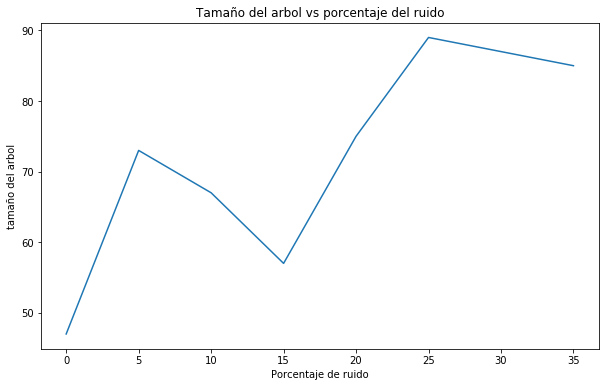

In [54]:
plt.figure(figsize=(10,6))
plt.plot(list(range(0,40,5)), tree_size_noyse)
plt.title('Tamaño del arbol vs porcentaje del ruido')
plt.ylabel('tamaño del arbol')
plt.xlabel('Porcentaje de ruido')
plt.show()

A partir del gráfico expuesto, se desprende que existe una relacion directa entre el tamaño del árbol y el procentaje de ruido. Se puede observar que a medida que el ruido aumenta, el tamaño del árbol también lo hace. A continuación, se realiza el gráfico de la performance:

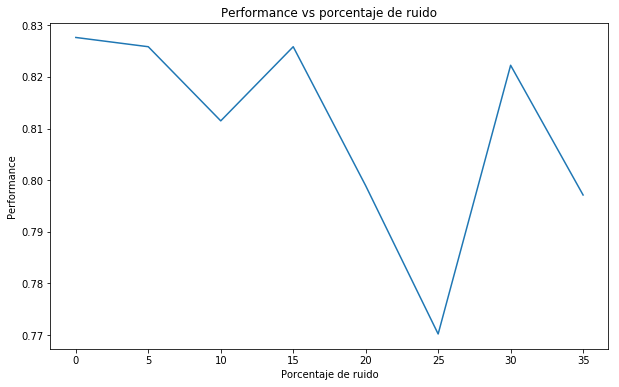

In [56]:
plt.figure(figsize=(10,6))
plt.plot(list(range(0,40,5)), acc_noyse)
plt.title('Performance vs porcentaje de ruido')
plt.ylabel('Performance')
plt.xlabel('Porcentaje de ruido')
plt.show()

A partir de este gráfico se puede concluir que si bien existe una relacion inversa entre el porcentaje del ruido y la perfomance del arbol, esta relación parece ser leve. En otras palabras, cuando el porcentaje del ruido alcanza el 25% la performance sólo desciende un 7%. Ademas, luego conforme aumenta el porcentaje del ruido la performance se recupera pero nunca llega a los niveles iniciales.

## Análisis
Como se puede apreciar en los gráficos expuestos en los incisos 6.2 y 6.3, conforme aumenta el ruido en el atributo más importante, aumenta el tamaño del árbol denotando una relación directa entre estas dos variables. A si mismo, se puede apreciar que existe una leve relacio inversa entre el porcentaje del ruido y la performance del modelo. Incluso cuando el porcentaje del ruido en el atributo mas importante se incrementa, la perfomance del algoritmo,y por lo tanto, su capacidad de prediccion, se mantiene en niveles del orden del 77% (con un porctenaje de ruido igual a 25%) y 80% (cuando el porcentaje del ruido alcnaza el 35%).

# Naive Bayes

Al ser Naive Bayes otro de los algoritmos utilizados con frecuencia para los problemas de clasificación, se procede a implementarlo para comparar su comportamiento con el obtenido a partir de los arboles de decisión. A continuación se crearan diferente objetos *naive_bayes* que obedecen a diferentes distribuciones de probabilidad y se aplicará la función previamente implementada para hacer *cross validations* con el objetivo de escoger la distribución que mejor se ajuste a los datos: 

In [51]:
bayes_bern = sk.naive_bayes.BernoulliNB()
bayes_compl = sk.naive_bayes.ComplementNB()
bayes_mult = sk.naive_bayes.MultinomialNB()
bayes_gau= sk.naive_bayes.GaussianNB()
list_bayes = [bayes_bern, bayes_compl, bayes_mult, bayes_gau]
for i in list_bayes:
    print(cross_val_nuevo(dev_x, dev_y, 5, i, 'roc'))

([0.826, 0.822, 0.823, 0.817, 0.815], [0.801, 0.814, 0.81, 0.835, 0.843])
([0.48, 0.491, 0.502, 0.497, 0.496], [0.546, 0.503, 0.46, 0.48, 0.481])
([0.495, 0.49, 0.492, 0.492, 0.5], [0.487, 0.506, 0.505, 0.504, 0.466])
([0.539, 0.518, 0.508, 0.537, 0.584], [0.545, 0.507, 0.496, 0.524, 0.527])


A través de las evaluaciones, se puede concluir que la mejor distribución es la de Bernoulli, lo que parece consistente teniendo en cuenta que el atributo a predecir es binario. A continuación, se procede a entrenar un árbol del tipo Bernoulli y a informar sus probabilidades previas y condicionales:

In [27]:
bayes_bern.fit(dev_x,dev_y)
prob_prev = np.exp(bayes_bern.class_log_prior_)
print(prob_prev)
prob_feat = np.exp(bayes_bern.feature_log_prob_)
print(prob_feat)

[0.32386772 0.67613228]
[[0.99889258 0.99889258 0.99889258 0.99889258 0.99889258 0.00110742
  0.99889258 0.99889258 0.99889258 0.99889258 0.99889258 0.96899225
  0.99889258 0.99889258 0.99889258 0.99889258 0.99889258 0.99889258
  0.99889258 0.99889258 0.00110742 0.99889258 0.99889258 0.99889258
  0.99889258 0.99889258 0.99889258 0.99889258 0.99889258]
 [0.99946893 0.99946893 0.99946893 0.99946893 0.99946893 0.11949018
  0.99946893 0.99946893 0.99946893 0.99946893 0.99946893 0.9755709
  0.99946893 0.99946893 0.99946893 0.99946893 0.99946893 0.99946893
  0.99946893 0.99946893 0.62506638 0.99946893 0.99946893 0.99946893
  0.99946893 0.99946893 0.99946893 0.99946893 0.99946893]]


# Comparación de algoritmos

Ahora que conocemos el desempeño de ambos algoritmos, se pocederá a realizar una evualuación y comparación de estos utilizando los datos de testeo. Inicialmente debemos crear y entrenar el modelo de mejor desempeño en cada caso utilizando el set de entrenamiento. En el caso de arboles de decisión, para encontrar los parametro de dicho árbol se empleará *GridSearchCV*:

In [34]:
param = {'max_depth': np.arange(1, 30),'criterion' : ('entropy','gini')}
tree = sk.model_selection.GridSearchCV(sk.tree.DecisionTreeClassifier(), param)
tree.fit(dev_x, dev_y)
tree.best_params_

/home/juan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'criterion': 'entropy', 'max_depth': 6}

Tal como el análisis previo lo habia mostrado, la mejor profundiad es 6 y el mejor método es *entropy*. Puesto que previamente se demostró que el mejor tipo de *naive bayes* es el de distribución bernoulli, se utilizará este modelo y el árbol con los hiperparámetros encontrados para realizar las validaciones correspondientes utilizando *ROC AUC* como métrica de performance, asi como calcular su medias y los desviaciones estandar de los resultados para volverlos comparables:

In [57]:
tree = sk.tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 6)
bayes = sk.naive_bayes.BernoulliNB()
tree_scores = cross_val_nuevo(dev_x, dev_y, 5, tree, 'roc')
bayes_scores = cross_val_nuevo(dev_x, dev_y, 5, bayes, 'roc')
tree_means = [np.array(tree_scores[0]).mean(),np.array(tree_scores[1]).mean()]
tree_sd = [np.array(tree_scores[0]).std(),np.array(tree_scores[1]).std()]
bayes_means = [np.array(bayes_scores[0]).mean(),np.array(bayes_scores[1]).mean()]
bayes_sd = [np.array(bayes_scores[0]).std(),np.array(bayes_scores[1]).std()]
print(tree_means, tree_sd,'\n', bayes_means, bayes_sd)

[0.828, 0.7914000000000001] [0.004335896677735764, 0.023474241201793932] 
 [0.8204, 0.8203999999999999] [0.0016248076809271936, 0.006711184694224975]


Como se puede apreciar, ambos modelos presentan buenas medidas de desempeño, pero aún cuando el comportamiento para los casos de entrenamiento es bastante parecido, se evidencia que para los casos de validación el algoritmo de *naive_bayes* tiene una media más alta y un menor desvío estándar. A continuación se procede entrenar los modelos y a evaluar su desempeño con set de testeo:

In [58]:
tree.fit(dev_x, dev_y)
tree_pred = tree.predict(test_x)
bayes.fit(dev_x, dev_y)
bayes_pred = bayes.predict(test_x)
perf_tree = sk.metrics.roc_auc_score(test_y,tree_pred)
perf_bayes = sk.metrics.roc_auc_score(test_y,bayes_pred)
print(perf_tree,perf_bayes)

0.8060438755069136 0.8154639175257732


Como se esperaba, ambas modelos tuvieron buenas medidas de desempeño, siendo la obtenida aquella obtenida a partir del modelo *naive bayes* mejor que aquella que se deriva del árbol de decisión.